In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/full_dataset.parquet'
output_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/clean_dataset.parquet'

In [6]:
print(f"Loading from {data_path}...")
df = pd.read_parquet(data_path)
print(f"Loaded {len(df):,} rows.")

Loading from /content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/full_dataset.parquet...
Loaded 47,248,845 rows.


In [7]:
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Handling Negative and Zero Values

In [8]:
neg_duration = df[df['trip_duration_min'] <= 0]
neg_distance = df[df['trip_distance'] <= 0]
neg_fare = df[df['fare_amount'] <= 0]
zero_pass = df[df['passenger_count'] <= 0]
garbage_trips = df[(df['trip_duration_min'] <= 0) & (df['trip_distance'] <= 0)]

print(f"Total Rows: {len(df):,}")
print("-" * 30)
print(f"1. Invalid Duration (<= 0 min): {len(neg_duration):,} rows")
print(f"2. Invalid Distance (<= 0 mi) : {len(neg_distance):,} rows")
print(f"3. Invalid Fare     (<= $0)   : {len(neg_fare):,} rows")
print(f"4. Zero Passengers            : {len(zero_pass):,} rows")
print(f"5. Garbage (0 dist & 0 dur).  : {len(garbage_trips):,} rows")

Total Rows: 47,248,845
------------------------------
1. Invalid Duration (<= 0 min): 51,380 rows
2. Invalid Distance (<= 0 mi) : 282,241 rows
3. Invalid Fare     (<= $0)   : 31,044 rows
4. Zero Passengers            : 8,214 rows
5. Garbage (0 dist & 0 dur).  : 49,368 rows


In [9]:
valid_mask = (
    (df['trip_duration_min'] > 0) &
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0) &
    (df['passenger_count'] > 0)
)

In [10]:
df_clean_step1 = df[valid_mask].copy()

dropped_rows = len(df) - len(df_clean_step1)
percentage_dropped = (dropped_rows / len(df)) * 100
print(f"Dropped {dropped_rows:,} rows, which is {percentage_dropped:.2f}% of the original dataframe.")

Dropped 312,054 rows, which is 0.66% of the original dataframe.


# Improbable Positives (Upper Limit)

In [11]:
df['speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60)

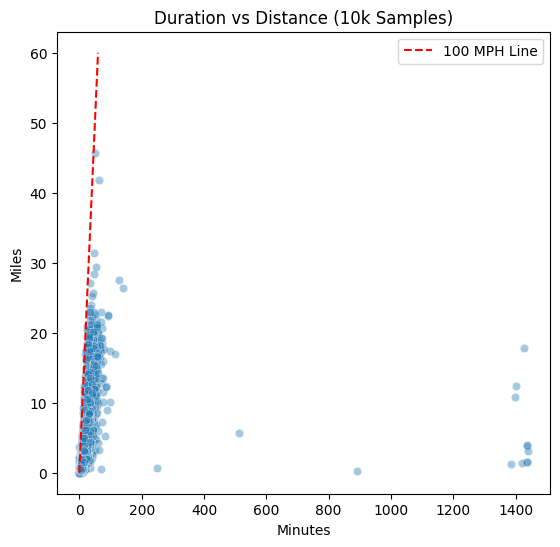

In [12]:
plt.figure(figsize=(14, 6))

# Plot 1: Duration vs Distance (The logic check)
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df.sample(10000, random_state=42),
    x='trip_duration_min',
    y='trip_distance',
    alpha=0.4
)
plt.title('Duration vs Distance (10k Samples)')
plt.xlabel('Minutes')
plt.ylabel('Miles')
# Add a line for "100 MPH"
plt.plot([0, 60], [0, 60], 'r--', label='100 MPH Line')
plt.legend()
plt.show()

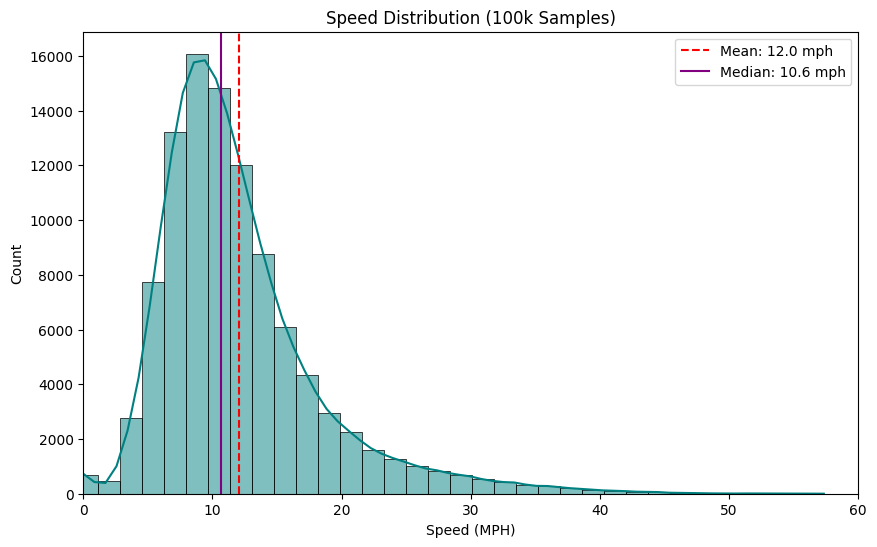

In [13]:
# Take a random sample of 100k rows for visualization
# This runs instantly and looks identical to the full plot
plot_df = df.sample(n=100000, random_state=42)

# Filter for the realistic range (0-60 mph) just for the plot
plot_data = plot_df[plot_df['speed_mph'] < 60]

plt.figure(figsize=(10, 6))

# Histogram with KDE (Kernel Density Estimation)
sns.histplot(plot_data['speed_mph'], bins=100, kde=True, color='teal')

# Statistics
mean_val = plot_data['speed_mph'].mean()
median_val = plot_data['speed_mph'].median()

plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f} mph')
plt.axvline(median_val, color='purple', linestyle='-', label=f'Median: {median_val:.1f} mph')

plt.title('Speed Distribution (100k Samples)')
plt.xlabel('Speed (MPH)')
plt.xlim(0, 60)
plt.legend()
plt.show()

- Duration < 240 min (4 Hours): The scatter plot revealed a cluster of system errors at 1440 mins (24h).
Valid NYC trips, even with traffic/airports, rarely exceed 3-4 hours.
- Distance < 100 miles: This covers the entire NYC metro area including far suburbs.
- Trips beyond this are outliers or data errors not useful for city-level demand forecasting.
- Speed < 100 MPH:  Trips above this line in the scatter plot are most likely GPS errors.

In [14]:
upper_limit_mask = (
    (df['trip_duration_min'] < 240) &
    (df['trip_distance'] < 100) &
    (df['speed_mph'] < 100)
)

In [15]:
df_clean_step2 = df[upper_limit_mask].copy()
dropped_rows = len(df) - len(df_clean_step2)
percentage_dropped = (dropped_rows / len(df)) * 100
print(f"Dropped {dropped_rows:,} rows, which is {percentage_dropped:.2f}% of the original dataframe.")

Dropped 149,631 rows, which is 0.32% of the original dataframe.


# Spatial Anomalies

In [16]:
# Install folium if not already installed
!pip install folium -q

import folium
from folium.plugins import HeatMap

# 1. Define the Proposed Bounding Box Coordinates
min_lat, max_lat = 40.5, 41
min_lon, max_lon = -74.3, -73.70

# 2. Initialize Map centered on NYC
nyc_map = folium.Map(location=[40.73, -73.93], zoom_start=10, tiles='OpenStreetMap')

# 3. Add the Data as a Heatmap (Using the 100k sample)
# We use a heatmap because plotting 100k dots individually makes the map laggy
heat_data = plot_df[['pickup_latitude', 'pickup_longitude']].dropna().values.tolist()
HeatMap(heat_data, radius=10, blur=15, min_opacity=0.4).add_to(nyc_map)

# 4. Draw the Bounding Box (Red Rectangle)
# We check if this box captures the "Heat" (Data) effectively
folium.Rectangle(
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    color='red',
    weight=2,
    fill=False,
    popup='Proposed NYC Boundary'
).add_to(nyc_map)

# 5. Display
nyc_map

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Define the Optimized Bounding Box
nyc_min_lat, nyc_max_lat = 40.5, 41
nyc_min_lon, nyc_max_lon = -74.3, -73.7

In [18]:
spatial_mask = (
    (df['pickup_latitude'].between(nyc_min_lat, nyc_max_lat)) &
    (df['pickup_longitude'].between(nyc_min_lon, nyc_max_lon)) &
    (df['dropoff_latitude'].between(nyc_min_lat, nyc_max_lat)) &
    (df['dropoff_longitude'].between(nyc_min_lon, nyc_max_lon))
)

In [19]:
df_clean_step3 = df[spatial_mask].copy()

In [20]:
dropped_rows = len(df) - len(df_clean_step3)
percentage_dropped = (dropped_rows / len(df)) * 100
print(f"Dropped {dropped_rows:,} rows, which is {percentage_dropped:.2f}% of the original dataframe.")

Dropped 870,880 rows, which is 1.84% of the original dataframe.


# Final Consolidated Cleaning Pipeline

In [21]:
df = pd.read_parquet(data_path)
initial_rows = len(df)
print(f"Loaded {initial_rows:,} rows.")

print("Creating features for cleaning (duration, speed)...")
df['trip_duration_min'] = (pd.to_datetime(df['tpep_dropoff_datetime']) - pd.to_datetime(df['tpep_pickup_datetime'])).dt.total_seconds() / 60
df['speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60 + 0.001)

Loaded 47,248,845 rows.
Creating features for cleaning (duration, speed)...


In [22]:
nyc_min_lat, nyc_max_lat = 40.5, 41
nyc_min_lon, nyc_max_lon = -74.3, -73.7

In [23]:
final_mask = (
    (df['trip_duration_min'] > 0) &
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0) &
    (df['passenger_count'] > 0) &
    (df['trip_duration_min'] < 240) &    # Max 4 hours
    (df['trip_distance'] < 100) &       # Max 100 miles
    (df['speed_mph'] < 100) &            # Max 100 MPH
    (df['total_amount'] < 1000) &        # Max $1000 fare
    (df['pickup_latitude'].between(nyc_min_lat, nyc_max_lat)) &
    (df['pickup_longitude'].between(nyc_min_lon, max_lon)) &
    (df['dropoff_latitude'].between(nyc_min_lat, nyc_max_lat)) &
    (df['dropoff_longitude'].between(nyc_min_lon, max_lon)) &
    (df['RateCodeID'].isin([1, 2, 3, 4, 5, 6]))
)

print("Applying filters...")
df_clean = df[final_mask].copy()

Applying filters...


In [24]:
final_rows = len(df_clean)
dropped_rows = initial_rows - final_rows
print(f"Initial Rows: {initial_rows:,}")
print(f"Final Rows:   {final_rows:,}")
print(f"Rows Dropped: {dropped_rows:,} ({dropped_rows/initial_rows:.2%})")

Initial Rows: 47,248,845
Final Rows:   46,084,048
Rows Dropped: 1,164,797 (2.47%)


# Temporal Gap Check

In [25]:
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
daily_counts = df['pickup_date'].value_counts().sort_index()

In [26]:
full_date_range = pd.date_range(start=daily_counts.index.min(), end=daily_counts.index.max())
missing_dates = full_date_range.difference(pd.to_datetime(daily_counts.index))

if len(missing_dates) > 0:
    print(f"WARNING: There are {len(missing_dates)} missing days in the timeline!")

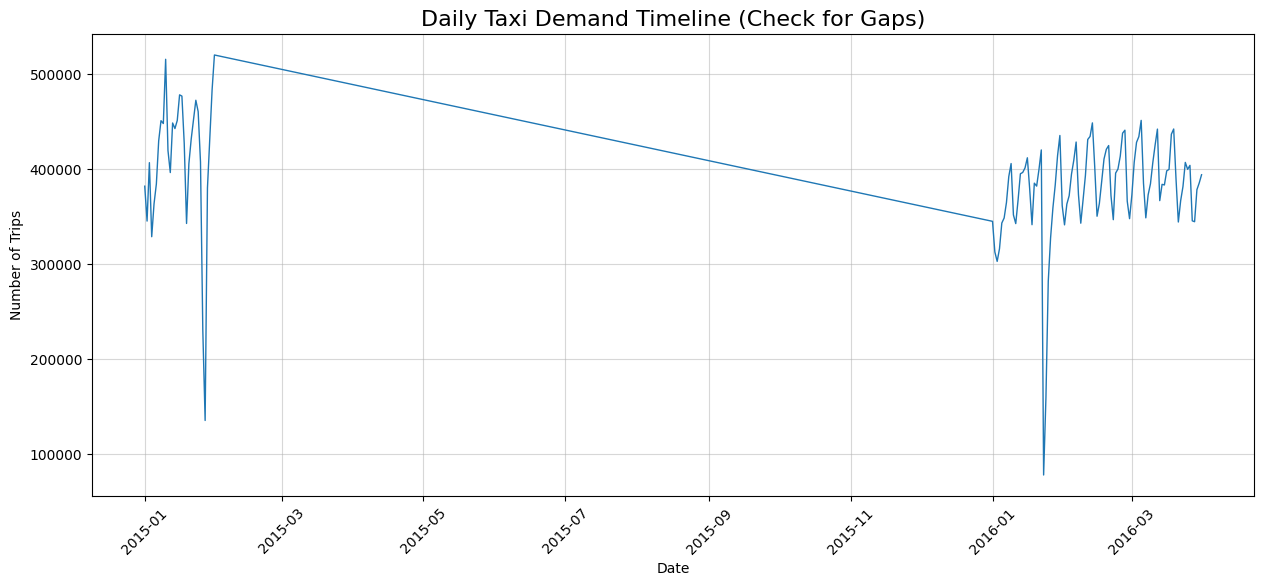

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(daily_counts.index, daily_counts.values, color='tab:blue', linewidth=1)
plt.title('Daily Taxi Demand Timeline (Check for Gaps)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True, alpha=0.5)
plt.xticks(rotation=45)
plt.show()

In [28]:
print("\nSeparating 2015 data from 2016 data...")
df_2015 = df_clean[df_clean['tpep_pickup_datetime'].dt.year == 2015].copy()
df_2016 = df_clean[df_clean['tpep_pickup_datetime'].dt.year == 2016].copy()


Separating 2015 data from 2016 data...


In [29]:
figures_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/'

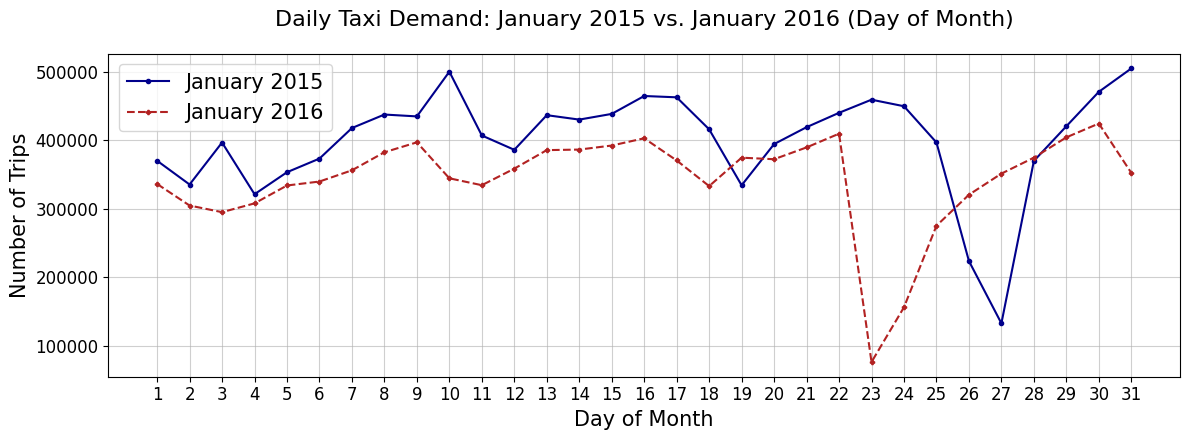

In [30]:
jan_2015 = df_2015[df_2015['tpep_pickup_datetime'].dt.month == 1].copy()
jan_2016 = df_2016[df_2016['tpep_pickup_datetime'].dt.month == 1].copy()

jan_2015['day_of_month'] = jan_2015['tpep_pickup_datetime'].dt.day
jan_2016['day_of_month'] = jan_2016['tpep_pickup_datetime'].dt.day

daily_counts_2015_dom = jan_2015['day_of_month'].value_counts().sort_index()
daily_counts_2016_dom = jan_2016['day_of_month'].value_counts().sort_index()

plt.figure(figsize=(12, 4.5))
plt.plot(daily_counts_2015_dom.index, daily_counts_2015_dom.values, label='January 2015', color='darkblue', marker='o', linestyle='-', linewidth=1.5, markersize=3)
plt.plot(daily_counts_2016_dom.index, daily_counts_2016_dom.values, label='January 2016', color='firebrick', marker='P', linestyle='--', linewidth=1.5, markersize=3)

plt.title('Daily Taxi Demand: January 2015 vs. January 2016 (Day of Month)', fontsize=16, pad=20)
plt.xlabel('Day of Month', fontsize=15)
plt.ylabel('Number of Trips', fontsize=15)
plt.grid(True, alpha=0.6)
plt.legend(fontsize=15)
plt.xticks(daily_counts_2015_dom.index) # Ensure all days are shown on x-axis
plt.tick_params(axis='x', labelsize=12) # Increase x-tick font size
plt.tick_params(axis='y', labelsize=12) # Increase y-tick font size
plt.tight_layout()
plt.savefig(os.path.join(figures_path, "january_demand.svg"), format="svg")
plt.show()

In [31]:
archive_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/archive_2015_data.parquet'
print(f"Archiving {len(df_2015):,} rows of 2015 data to:\n -> {archive_path}")
df_2015.to_parquet(archive_path)

Archiving 12,402,757 rows of 2015 data to:
 -> /content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/archive_2015_data.parquet


In [32]:
df_2016.sort_values(by='tpep_pickup_datetime', inplace=True)
df_2016.reset_index(drop=True, inplace=True)

In [33]:
display(df_2016.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration_min,speed_mph
count,3.368129e+07,33681291,33681291,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07,3.368129e+07
mean,1.536946e+00,2016-02-16 16:39:41.596000,2016-02-16 16:53:04.292000,1.666306e+00,2.905184e+00,-7.397219e+01,4.075094e+01,1.027361e+00,-7.397230e+01,4.075148e+01,1.335517e+00,1.244071e+01,3.309162e-01,4.988145e-01,1.762586e+00,2.956380e-01,2.999961e-01,1.562868e+01,1.337827e+01,1.191485e+01
min,1.000000e+00,2016-01-01 00:00:00,2016-01-01 00:00:11,1.000000e+00,1.000000e-02,-7.429125e+01,4.050067e+01,1.000000e+00,-7.429999e+01,4.050129e+01,1.000000e+00,1.000000e-02,-4.500000e-01,0.000000e+00,-1.700000e-01,-5.540000e+00,0.000000e+00,3.100000e-01,1.666667e-02,2.759551e-03
25%,1.000000e+00,2016-01-26 00:24:26.500000,2016-01-26 00:38:59,1.000000e+00,1.000000e+00,-7.399181e+01,4.073757e+01,1.000000e+00,-7.399133e+01,4.073611e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00,6.483333e+00,7.840123e+00
50%,2.000000e+00,2016-02-17 11:55:52,2016-02-17 12:10:42,1.000000e+00,1.700000e+00,-7.398184e+01,4.075415e+01,1.000000e+00,-7.397993e+01,4.075450e+01,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.350000e+00,0.000000e+00,3.000000e-01,1.176000e+01,1.068333e+01,1.047619e+01
75%,2.000000e+00,2016-03-10 00:21:54,2016-03-10 00:34:58,2.000000e+00,3.100000e+00,-7.396774e+01,4.076820e+01,1.000000e+00,-7.396338e+01,4.076969e+01,2.000000e+00,1.400000e+01,5.000000e-01,5.000000e-01,2.350000e+00,0.000000e+00,3.000000e-01,1.730000e+01,1.718333e+01,1.419452e+01
max,2.000000e+00,2016-03-31 23:59:59,2016-04-01 01:02:41,9.000000e+00,9.574000e+01,-7.370024e+01,4.099356e+01,6.000000e+00,-7.370000e+01,4.099993e+01,5.000000e+00,9.980000e+02,6.488700e+02,7.930000e+01,8.500000e+02,9.245000e+02,3.000000e-01,9.983000e+02,2.397500e+02,1.000000e+02
std,4.986332e-01,NaN,NaN,1.320865e+00,3.528124e+00,3.719229e-02,2.758233e-02,2.080612e-01,3.390580e-02,3.163443e-02,4.835034e-01,1.010404e+01,4.495880e-01,2.820501e-02,2.378295e+00,1.586623e+00,1.369591e-03,1.262433e+01,1.022451e+01,6.219547e+00


In [34]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33681291 entries, 0 to 33681290
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int8          
 1   tpep_pickup_datetime   datetime64[ms]
 2   tpep_dropoff_datetime  datetime64[ms]
 3   passenger_count        int8          
 4   trip_distance          float32       
 5   pickup_longitude       float32       
 6   pickup_latitude        float32       
 7   RateCodeID             int8          
 8   store_and_fwd_flag     category      
 9   dropoff_longitude      float32       
 10  dropoff_latitude       float32       
 11  payment_type           int8          
 12  fare_amount            float32       
 13  extra                  float32       
 14  mta_tax                float32       
 15  tip_amount             float32       
 16  tolls_amount           float32       
 17  improvement_surcharge  float32       
 18  total_amount        

In [35]:
print(f"\nSaving final clean dataset to {output_path}...")
df_2016.to_parquet(output_path)


Saving final clean dataset to /content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/clean_dataset.parquet...
